dfc["threshold"] = 0.05 + 0.25*dfc["martyrdom_scaled"]

In [1]:
import load

df = load.data("groundout_formulas", season=18)

df = df[df['event_type']=='Sac']

df["martyrdom_scaled"] = load.player_attribute(df, 'batter', 'martyrdom', vibes=False, mods=True, items=True, broken_items=True)

df["indulgence_scaled"] = load.player_attribute(df, 'relevant_runner', 'indulgence', vibes=True, mods=True, items=True, broken_items=True)

df["tenaciousness_scaled"] = load.player_attribute(df, 'fielder', 'tenaciousness', vibes=True, mods=True, items=True, broken_items=True)

df["elongation"] = load.stadium_attribute(df, 'elongation', center=True)
df["inconvenience"] = load.stadium_attribute(df, 'inconvenience', center=True)

In [2]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [4]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
#for exclude_mod in []:
    #dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    
dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
#dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

len(dfc)

2706

In [32]:
dfc["bhype"] = dfc["batting_team_hype"]
dfc["phype"] = dfc["pitching_team_hype"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["marty2"] = dfc["martyrdom_scaled"] * (1 + 0.2*dfc["batting_team_hype"])
dfc["hypediff"] = (dfc["pitching_team_hype"] * (1 + 0.2*dfc["pitcher_vibes"])) - dfc["batting_team_hype"]

In [41]:
X = dfc[
    [
        "roll",
        "passed",
        "martyrdom_scaled",
        "bhype",
        "phype",
        #"indulgence_scaled",
        #"tenaciousness_scaled",
        #"elongation",
        #"inconvenience"



    ]
].copy()
#X = X[X["roll"] < 0.85]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.05
pins = [ (0.25, "martyrdom_scaled"), 
#(-0.03, "pitching_team_hype")

]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[1997    2]
 [   2  705]]
4 outliers
0.9985218033998522
0.05


[(1.0, 'roll'), (-0.0604238742288751, 'bhype'), (0.04979424516686662, 'phype')]

In [48]:

dfc["threshold"] = 0.05 + 0.25*dfc["martyrdom_scaled"] + 0.06*dfc["bhype"] - 0.05*dfc["phype"]

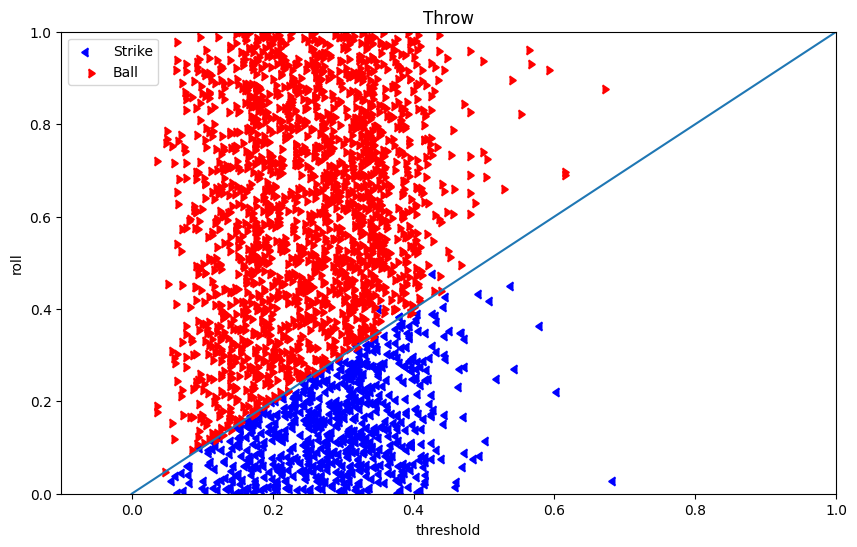

In [49]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Strike", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Ball", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Throw")
ax.set_xlim([-0.1, 1])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,event_type,roll,threshold,batting_team_hype,batter_name,pitcher_name,weather,day,game_id,play_count
7600,-0.003011,Sac,0.390732,0.393743,1.17,Cory Ross,Liam Snail,Weather.ECLIPSE,92,2cce64c2-ea49-48a5-84d5-32c14930eab9,237
4124,-0.000256,Sac,0.390334,0.390589,0.18,Alston Cerveza,Joshua Watson,Weather.SALMON,45,58bb8f87-4968-417f-8991-1f6512652874,187
5934,0.044718,Sac,0.474790,0.430072,0.87,Ruslan Greatness,Baldwin Breadwinner,Weather.BLACK_HOLE,74,c7d59bc4-5354-46e2-985b-ffaaca0b87f7,237
6332,0.045197,Sac,0.399542,0.354345,0.60,Sosa Hayes,Inky Rutledge,Weather.FLOODING,78,9ae3003f-19ac-4581-80a5-aa435245ea32,199


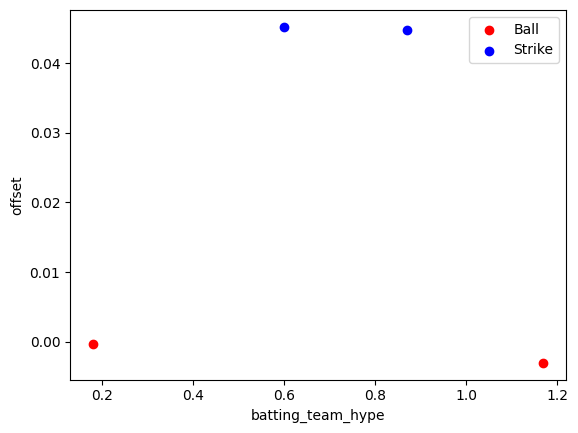

In [51]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["roll"] < 0.85]


fig, ax = plt.subplots(1)
x_val = "batting_team_hype"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Ball")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Strike")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold", "batting_team_hype", 
       "batter_name", "pitcher_name", "weather", 
       "day",  "game_id", "play_count"]].sort_values('offset')


In [35]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.8460652612230202
0.3265759853975572
